In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '..')

import numpy as np
import pandas as pd

from batchflow import Pipeline, B, V, I, M, C, plot, set_gpus
from batchflow.models.torch import TorchModel, VGGBlock
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from src.loader import ImagesDataset

set_gpus()

/notebooks/taine/notebooks/../batchflow/batchflow/plotter/cmaps.py:8: UserWarning: Trying to register the cmap 'batchflow' which already exists.
  register_cmap('batchflow', BATCHFLOW_CMAP)


`CUDA_VISIBLE_DEVICES` set to "7"


[7]

In [3]:
seed = 11
rng = np.random.default_rng(seed)

In [4]:
%%time

DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=seed)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

CPU times: user 20.5 s, sys: 32.1 s, total: 52.6 s
Wall time: 16.6 s


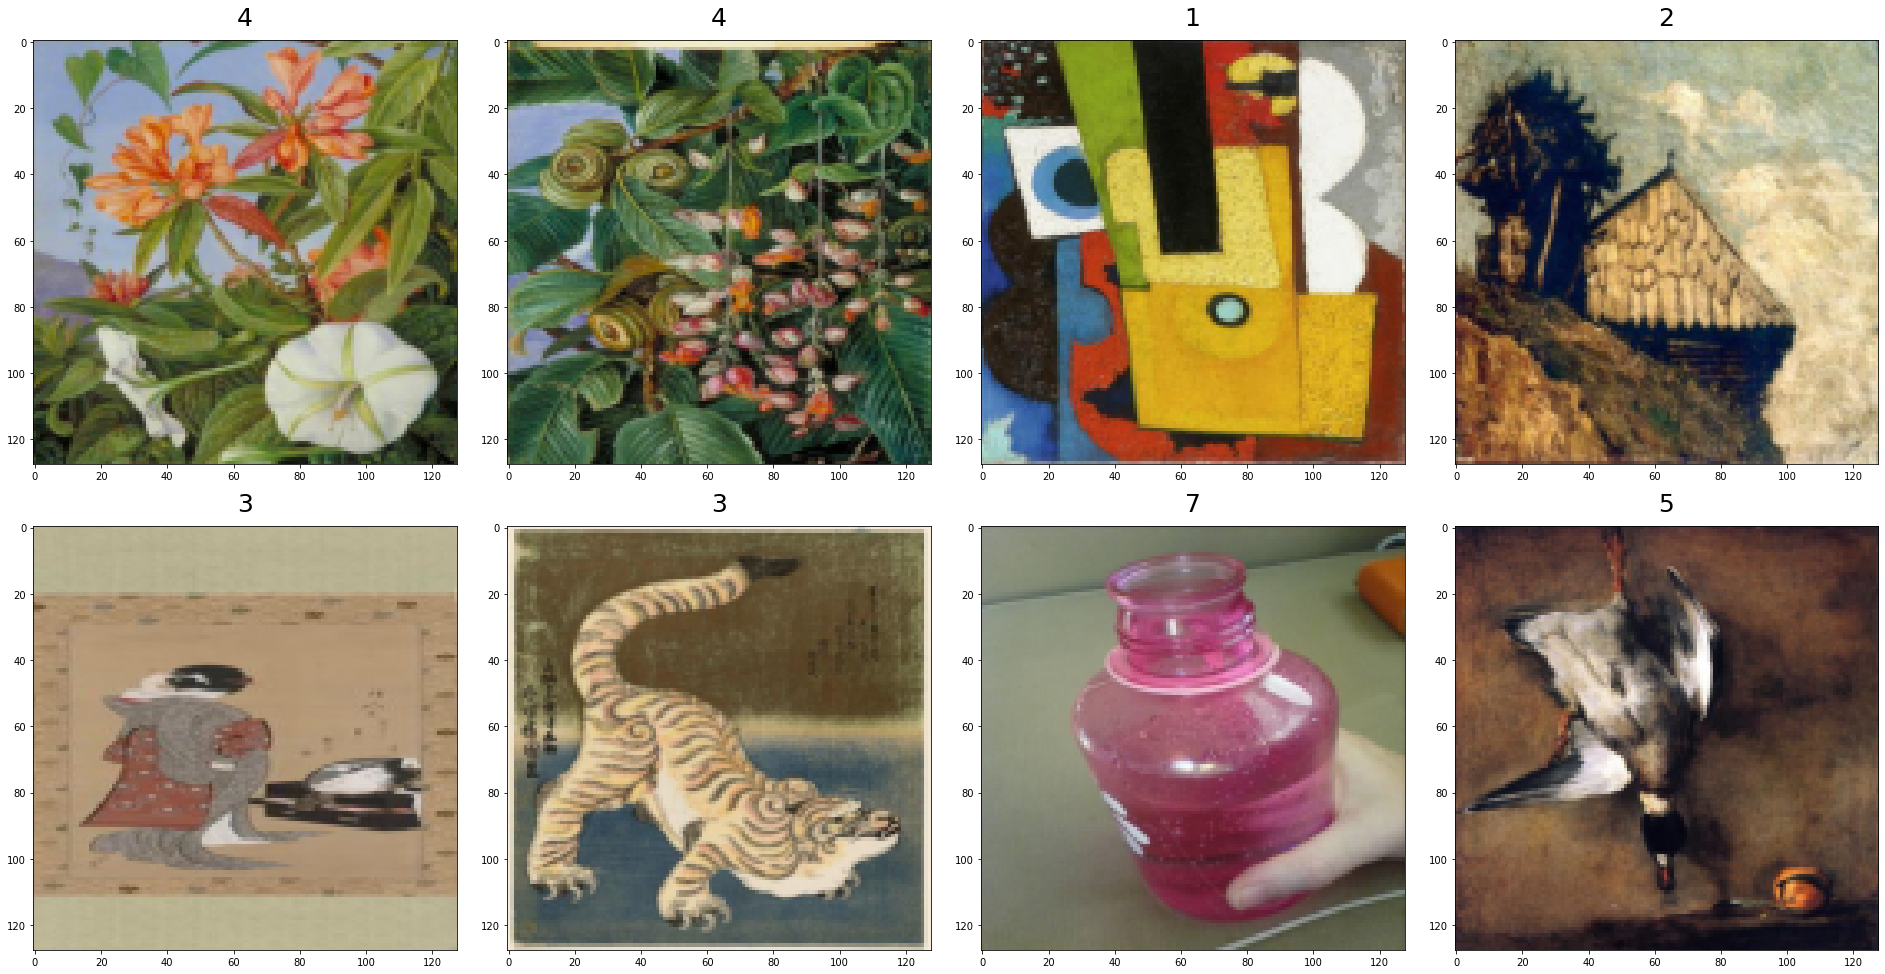

In [5]:
indices = rng.choice(range(dataset.size), 8)
images = list(dataset.images[indices])
labels = list(dataset.labels[indices])
plot(data=images, title=labels, combine='separate')

In [6]:
MODEL_PATH = '../models/vgg.torch'
model = TorchModel()
model.load(MODEL_PATH)

penultimate_module = model.model[1][-2]

penult = type('storage', (object,), {})

def get_activation(storage):
    def hook(model, _, output):
        storage.data = output.cpu().detach().numpy()
    return hook

hook_handle = penultimate_module.register_forward_hook(get_activation(penult))

In [7]:
infer_template = (
    Pipeline()
    .to_array(channels='first', dtype=np.float32)
    .init_variables('proba', 'predictions', 'metrics')
    .import_model('model', model)
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predicted_proba', 'predictions'],
                   save_to=[V('proba'), V('predictions')])
)

infer_pipeline = infer_template << dataset.test
batch = infer_pipeline.next_batch(dataset.test.size)
hook_handle.remove()

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


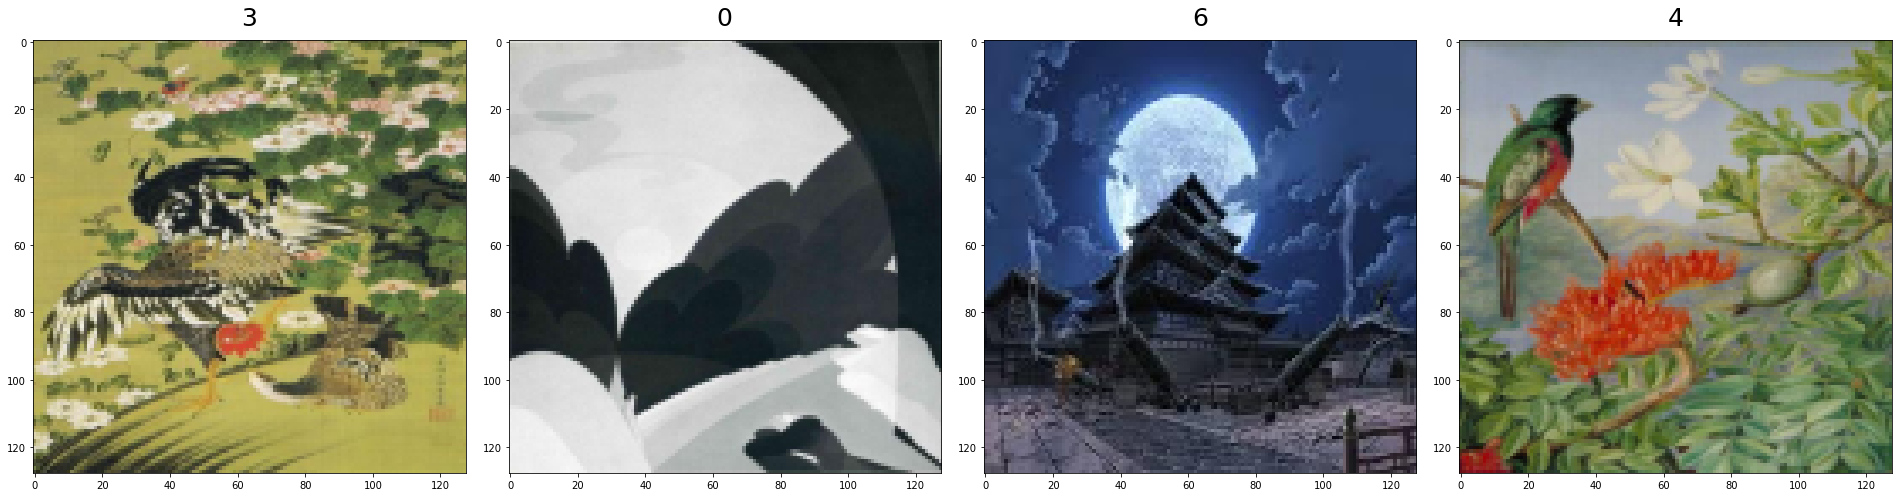

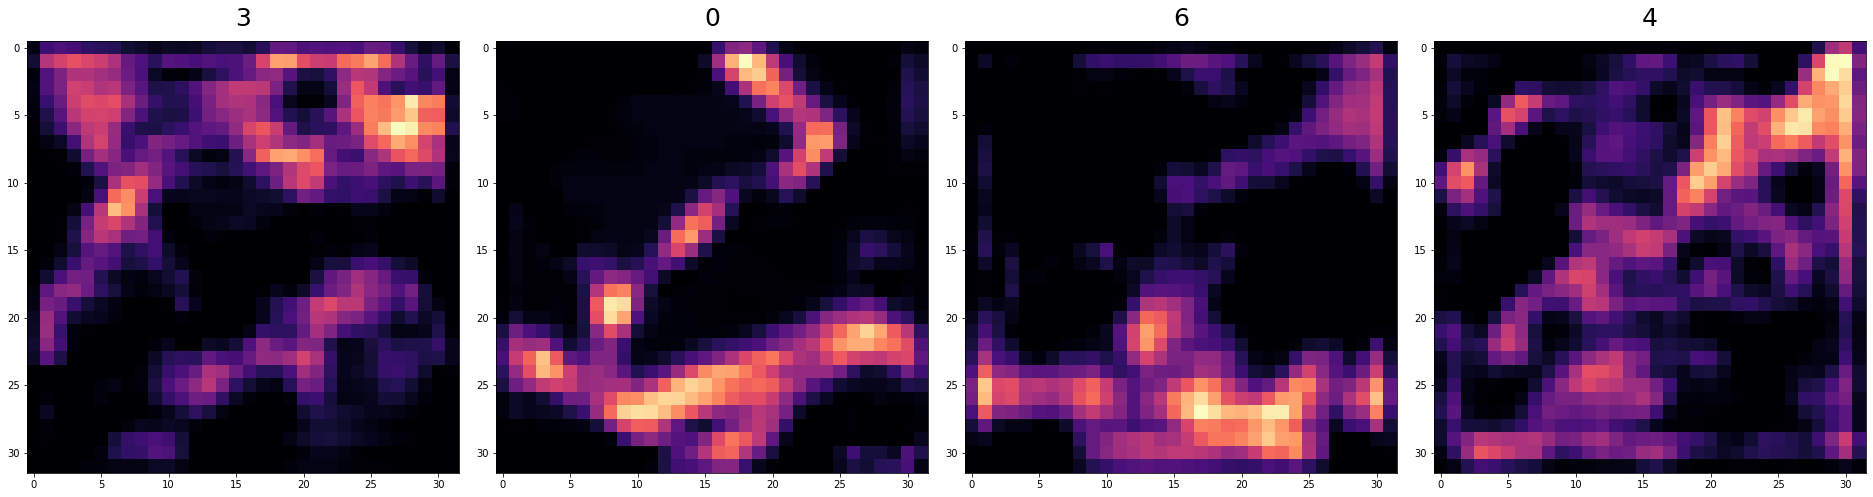

In [8]:
images = []
gradcams = []
labels = []

for index in rng.integers(0, dataset.test.size, 4):
    image = np.transpose(batch.images[index], (1, 2, 0))
    cam = model.get_gradcam(inputs=batch.images[index:index+1], layer=penultimate_module)
    images.append(image.reshape(*image.shape))
    gradcams.append(cam.reshape(*cam.shape, 1))
    label = batch.labels[index]
    labels.append(label)

plot(images, title=labels, combine='separate')
plot(gradcams, cmap='magma', title=labels, combine='separate')

In [9]:
features = penult.data.reshape(dataset.test.size, -1)
pca = PCA(n_components=100)
reduced = pca.fit_transform(features)

In [10]:
clusterer = KMeans(n_clusters=n_classes, verbose=1)
clustered = clusterer.fit_predict(reduced)

Initialization complete
Iteration 0, inertia 45729814.36203999
Iteration 1, inertia 34403128.50157803
Iteration 2, inertia 33833979.61428718
Iteration 3, inertia 33712258.0382018
Iteration 4, inertia 33624626.98021386
Iteration 5, inertia 33574744.9850628
Iteration 6, inertia 33570407.52909143
Iteration 7, inertia 33567850.05590682
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 44943384.91919138
Iteration 1, inertia 34843486.83818102
Iteration 2, inertia 34174280.34693985
Iteration 3, inertia 34025337.40785271
Iteration 4, inertia 33932049.764773004
Iteration 5, inertia 33865557.67581591
Iteration 6, inertia 33831836.50235516
Iteration 7, inertia 33801554.662336305
Iteration 8, inertia 33777017.18281758
Iteration 9, inertia 33713198.22566279
Iteration 10, inertia 33690770.49252313
Iteration 11, inertia 33677171.067079395
Iteration 12, inertia 33659208.743572205
Iteration 13, inertia 33623114.366068594
Iteration 14, inertia 33606983.97601414
I

In [11]:
true = batch.labels
predicted = np.argmax(infer_pipeline.v('predictions'), axis=1)

In [12]:
(predicted == true).mean()

0.6830985915492958

In [22]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [23]:
adjusted_rand_score(true, predicted), adjusted_mutual_info_score(true, predicted)

(0.4108367088093435, 0.44633353759792743)

In [25]:
adjusted_rand_score(true, clustered), adjusted_mutual_info_score(true, clustered)

(0.19874239655793002, 0.3103932059129061)

In [13]:
for i in range(n_classes):
    i_count = np.bincount(true[clustered == i], minlength=n_classes)
    print(f"{i}: {i_count} | max: {np.argmax(i_count)}")

0: [ 0  0  2  0  4 14  0  5] | max: 5
1: [ 2 17 11  7 13  5 11 20] | max: 7
2: [ 0  6  1 22  0  0  5  1] | max: 3
3: [ 0  0  1  0 16  0  0  0] | max: 4
4: [ 1  2 25  6 12  0  0  2] | max: 2
5: [ 2 40  5  3  0  0  1  0] | max: 1
6: [7 6 0 2 0 0 2 1] | max: 0
7: [0 1 1 2 0 0 0 0] | max: 3


In [32]:
# labels = dataset.label_encoder.inverse_transform(batch.labels)
# for cluster_num in range(n_classes):
#     cluster_images = batch.images[clustered == cluster_num]
#     cluster_images = list(cluster_images.transpose(0, 2, 3, 1))
#     cluster_true_labels = labels[clustered == cluster_num].tolist()
#     plot(cluster_images, title=cluster_true_labels, suptitle=f"cluster: {cluster_num}", suptitle_y=1, suptitle_size=30, combine='separate')